![logo_ironhack_blue 7](https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png)

# Project I | Deep Learning: Image Classification with CNN
#### Collaborators: Javier Dastas, Paola Rivera

## Task Description
Build a Convolutional Neural Network (CNN) model to classify images from a given dataset into predefined categories/classes.

## Dataset Chosen for Project
Kaggle - Animals10: The second dataset contains about 28,000 medium quality animal images belonging to 10 categories: dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant. The link is [here](https://www.kaggle.com/datasets/alessiocorrado99/animals10/data).

## Assessment Components

### **Part 1: Data Preprocessing**
   - Data loading and preprocessing (e.g., normalization, resizing, augmentation).
   - Create visualizations of some images, and labels.

In [43]:
# Important Libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import cv2
from PIL import Image

import os
from pathlib import Path

from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization

In [5]:
# Install the Image DataSet Access
#!pip install kagglehub

In [135]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:26<00:00, 23.1MB/s] 

Extracting files...


Path to dataset files: /Users/dastas/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [90]:
# Path to the folder containing images
file_path = './images'  # Replace with the path to your dataset
image_size = (128, 128)

In [66]:
def convert_imginfo_to_df(file_path):
    """
    Converts image information into a pandas DataFrame.
    
    Args:
        file_path (str): Path to the directory containing images.
        
    Returns:
        pd.DataFrame: DataFrame with columns 'file_path' and 'label'.
    """
    # Define valid extensions
    valid_extensions = (".jpg", ".jpeg", ".png")
    
    # Collect all image paths with valid extensions
    image_paths = []
    for ext in valid_extensions:
        image_paths.extend(Path(file_path).rglob(f"*{ext}"))  # Recursively find files matching each extension
    
    # Extract file paths and labels
    data = []
    for img_path in image_paths:
        label = img_path.parent.name  # Use the parent folder name as the label
        data.append({"file_path": str(img_path), "label": label})
    
    # Return the DataFrame
    return pd.DataFrame(data)

In [138]:
# Generate a DataFrame from the image information
image_df = convert_imginfo_to_df(file_path)

# Check the first few rows and column names of the DataFrame
print(image_df.head())
print(image_df.columns)

# Display the label counts
print("\nLabel counts:")
print(image_df['label'].value_counts())

                                           file_path  label
0  images/ragno/eb37b20620f61c22d2524518b7444f92e...  ragno
1  images/ragno/e834b70e2efc063ed1584d05fb1d4e9fe...  ragno
2  images/ragno/eb31b40e2cf6013ed1584d05fb1d4e9fe...  ragno
3  images/ragno/eb31b1072bf4093ed1584d05fb1d4e9fe...  ragno
4  images/ragno/eb32b50f20fd063ed1584d05fb1d4e9fe...  ragno
Index(['file_path', 'label'], dtype='object')

Label counts:
label
cane                  4863
ragno                 4821
gallina               3098
cavallo               2623
farfalla              2111
mucca                 1865
scoiattolo            1861
pecora                1819
gatto                 1667
elefante              1446
.ipynb_checkpoints       1
Name: count, dtype: int64


In [140]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

# Batch size
batch_size = 12

# Transformations for the images
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize to 128x128
    transforms.ToTensor(),         # Convert to Tensor
    transforms.Lambda(lambda x: x.permute(1, 2, 0))  # Change from (C, H, W) to (H, W, C)
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=file_path, transform=transform)

# Split into training (85%) and validation (15%) sets
total_size = len(full_dataset)
val_size = int(0.15 * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Convert the subsets into DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Display general information
print(f"Total number of images: {total_size}")
img, label = full_dataset[0]  # Load the first image and label
print("Image shape after transform:", img.shape)  # Should print (128, 128, 3)
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Get the class names
class_names = full_dataset.classes
print(f"\nClass names: {class_names}")

# Extract and display all the labels in the training and validation sets
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]
val_labels = [full_dataset.targets[i] for i in val_dataset.indices]

print("\nUnique labels in training set:", set(train_labels))
print("Unique labels in validation set:", set(val_labels))

# Optional: Display counts of each class in training and validation sets
train_class_counts = {class_names[i]: train_labels.count(i) for i in range(len(class_names))}
val_class_counts = {class_names[i]: val_labels.count(i) for i in range(len(class_names))}

print("\nClass counts in training set:", train_class_counts)
print("Class counts in validation set:", val_class_counts)

Total number of images: 26175
Image shape after transform: torch.Size([128, 128, 3])
Training set size: 22249
Validation set size: 3926

Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

Unique labels in training set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Unique labels in validation set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Class counts in training set: {'cane': 4121, 'cavallo': 2251, 'elefante': 1260, 'farfalla': 1770, 'gallina': 2645, 'gatto': 1416, 'mucca': 1573, 'pecora': 1540, 'ragno': 4097, 'scoiattolo': 1576}
Class counts in validation set: {'cane': 743, 'cavallo': 372, 'elefante': 186, 'farfalla': 341, 'gallina': 453, 'gatto': 251, 'mucca': 292, 'pecora': 279, 'ragno': 724, 'scoiattolo': 285}


In [142]:
#Translate from italian to english

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "ragno": "spider", "scoiattolo": "squirrel"}

# Replace the values in the 'label' column using the dictionary
class_names = [translate[name] for name in class_names]

print('Translated labels: ', class_names)

Translated labels:  ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']


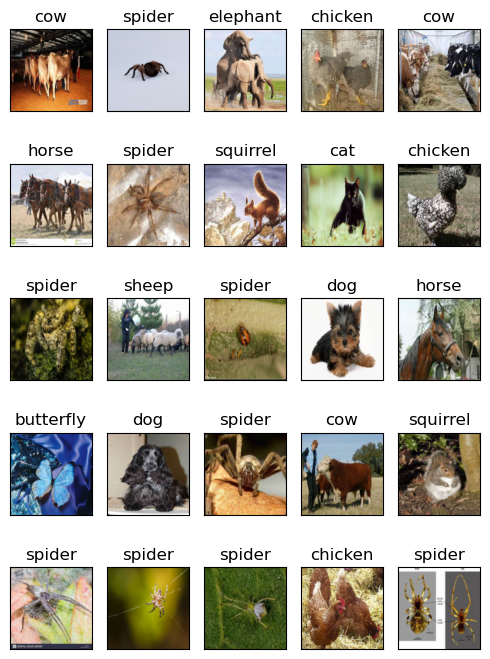

In [144]:
plt.figure(figsize=(5, 7))

for i in range(25):
    # Get the image and label from the training dataset
    img, label = train_dataset[i]
    
    # Convert the image tensor to a numpy array and adjust dimensions
    img = np.clip(img, 0, 1)  # Ensure pixel values are within [0, 1]
    
    # Plot the image
    plt.subplot(5, 5, i + 1)  # Create a 5x5 grid
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)  # Display the image
    plt.title(class_names[label])  # Display the corresponding class name

plt.tight_layout()
plt.show()

### **Part 2: Model Architecture**
   - Design a CNN architecture suitable for image classification.
   - Include convolutional layers, pooling layers, and fully connected layers.

In [709]:
#!pip install IPython

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,506 (619.16 KB)

 Trainable params: 157,866 (616.66 KB)

 Non-trainable params: 640 (2.50 KB)

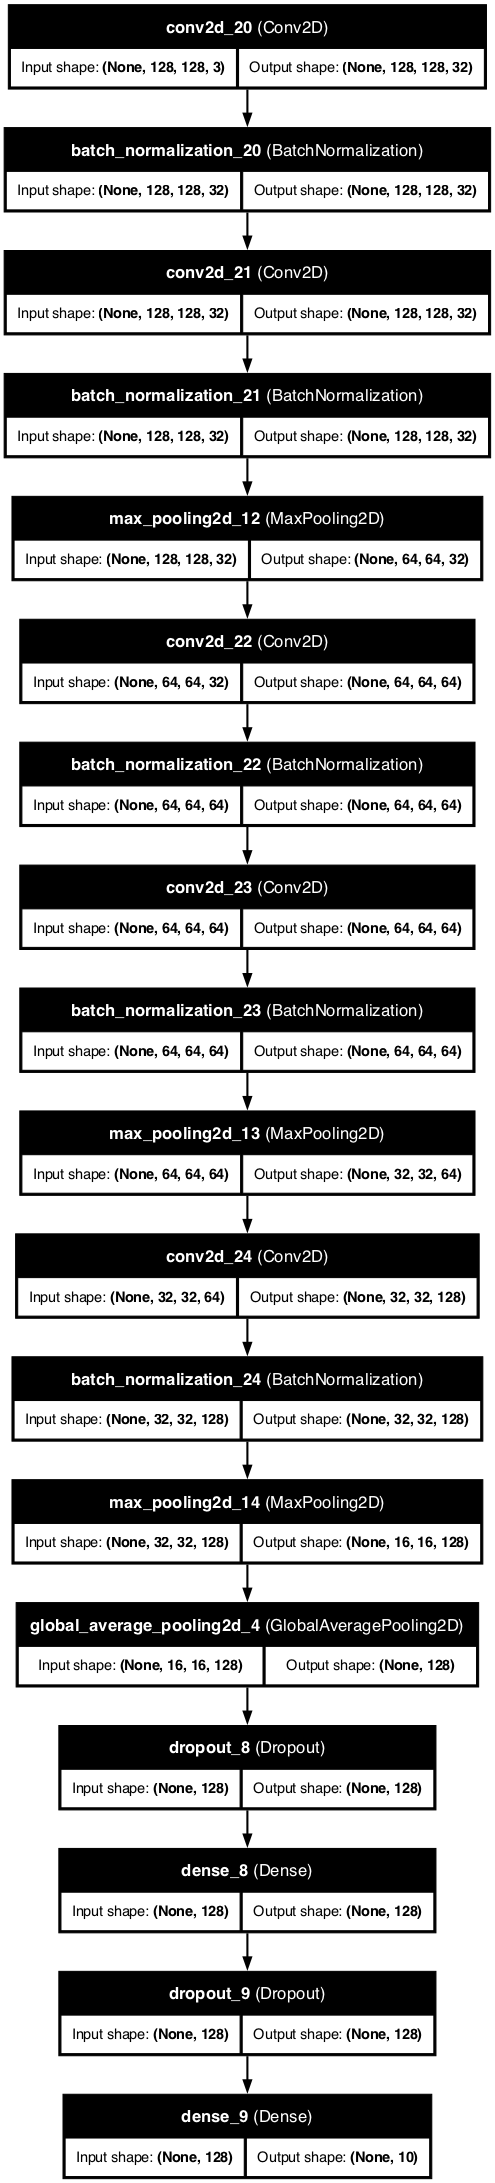

In [146]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
)

def create_cnn_model():
    # Model / data parameters
    input_shape = (128, 128, 3)  # Size of Image 128x128
    num_classes = 10
    
    model = Sequential(
    [
        Input(shape=input_shape),
        
        # First block
        Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
        BatchNormalization(),  # Normalize activations to stabilize training
        Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Second block
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Third block
        Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Global Average Pooling
        GlobalAveragePooling2D(),
        
        # Fully Connected Layers
        Dropout(0.1),  # Higher dropout rate for regularization
        Dense(128, activation="relu"),  # Additional dense layer with ReLU
        Dropout(0.5),  # Dropout for further regularization
        Dense(num_classes, activation="softmax"),
    ])

    return model

# Create and summarize the model
model = create_cnn_model()
model.summary()

# Visualize the model architecture
plot_model(model, to_file='my-cnn-model.png', show_shapes=True, show_layer_names=True,  dpi=75, expand_nested=True )

### **Part 3: Model Training**

- Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam). Utilize techniques such as early stopping to prevent overfitting.

In [148]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import math

# Calculate the steps per epoch and validation steps
train_steps = math.ceil(len(train_dataset) / train_loader.batch_size) # Number of batches in the training set
val_steps = math.ceil(len(val_dataset) / val_loader.batch_size) # Number of batches in the validation set

# Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Configure EarlyStopping to stop training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train without calling repeat()
history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=12,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=[early_stopping]
)

Epoch 1/12
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 224s 120ms/step - accuracy: 0.2691 - loss: 2.0967 - val_accuracy: 0.2188 - val_loss: 3.8762
Epoch 2/12
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 224s 120ms/step - accuracy: 0.4467 - loss: 1.5923 - val_accuracy: 0.5132 - val_loss: 1.3850
Epoch 3/12
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 225s 122ms/step - accuracy: 0.5257 - loss: 1.3842 - val_accuracy: 0.4289 - val_loss: 2.1146
Epoch 4/12
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 226s 122ms/step - accuracy: 0.5786 - loss: 1.2299 - val_accuracy: 0.5772 - val_loss: 1.3363
Epoch 5/12
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 227s 123ms/step - accuracy: 0.6131 - loss: 1.1450 - val_accuracy: 0.6398 - val_loss: 1.0935
Epoch 6/12
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 227s 122ms/step - accuracy: 0.6424 - loss: 1.0517 - val_accuracy: 0.6381 - val_loss: 1.0865
Epoch 7/12
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 226s 122ms/step - accuracy: 0.6760 - loss: 0.9716 - val_accuracy: 0.6164 - val_loss: 1.2037
Epoch 8/12
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 227s 122ms/step - ac

### **Part 4: Model Evaluation**
- Evaluate the trained model on a separate validation set.
- Compute and report metrics such as accuracy, precision, recall, and F1-score.
- Visualize the confusion matrix to understand model performance across different classes.

328/328 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7256 - loss: 0.8012
Validation Loss: 0.8018091320991516
Validation Accuracy: 0.7198166251182556
328/328 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
Len true_classes: 3926
Len predicted_classes: 3926
Classification Report:
              precision    recall  f1-score   support

        cane       0.80      0.70      0.75       743
     cavallo       0.65      0.84      0.73       372
    elefante       0.83      0.70      0.76       186
    farfalla       0.72      0.84      0.78       341
     gallina       0.76      0.83      0.79       453
       gatto       0.70      0.59      0.64       251
       mucca       0.59      0.71      0.65       292
      pecora       0.79      0.45      0.57       279
       ragno       0.96      0.65      0.77       724
  scoiattolo       0.47      0.89      0.61       285

    accuracy                           0.72      3926
   macro avg       0.73      0.72      0.71      3926
weighted avg       0.76   

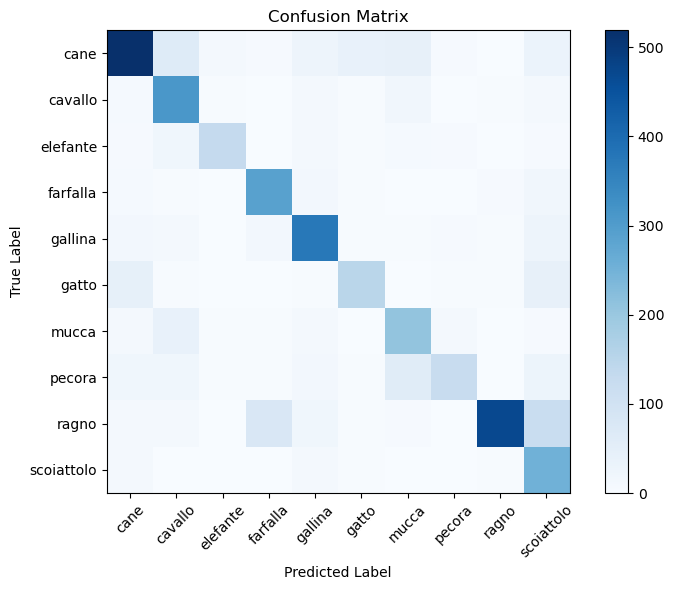

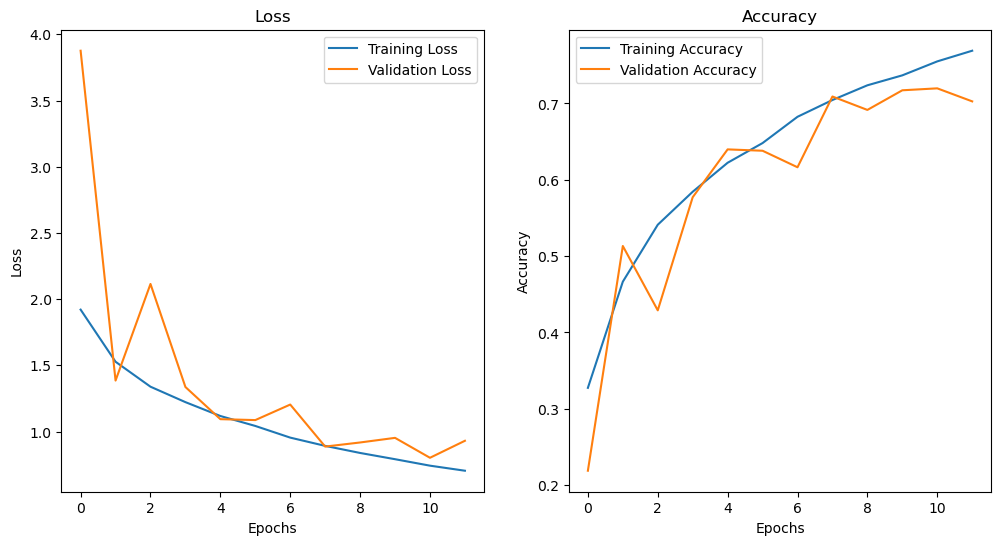

In [150]:
# Evaluate the model
val_loss, val_accuracy = model. evaluate(val_loader)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Generate predictions
predictions = model. predict(val_loader)
predicted_classes = np. argmax(predictions, axis=1)

# Get true labels from val_loader
true_classes = []
for _, labels in val_loader:
    true_classes. extend(labels. numpy()) # Extract true labels

# Make sure lengths match
print(f"Len true_classes: {len(true_classes)}")
print(f"Len predicted_classes: {len(predicted_classes)}")

# Get class names from val_loader original dataset
class_labels = list(full_dataset.class_to_idx.keys())

# Generate classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Visualize training history: Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [156]:
# Save your model if not already done
model.save("my_cnn_model_v1.h5")

print("Custom CNN Classificaiton Model saved: 'my_cnn_model_v1.h5'")

Custom CNN Classificaiton Model saved: 'my_cnn_model_v1.h5'


### **Part 5: Transfer Learning**
- Evaluate the accuracy of your model on a pre-trained models like ImagNet, VGG16, Inception... (pick one an justify your choice)
You may find this link helpful.
This is the Pytorch version.
- Perform transfer learning with your chosen pre-trained models i.e., you will probably try a few and choose the best one.

#### **Define the Model: Freeze the Model Base**

In [69]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model to retain pre-trained features
base_model.trainable = False

# Add a custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling layer
x = Dense(128, activation='relu')(x)  # Dense layer
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(10, activation='softmax')(x)  # Output layer for 10 classes

# Define the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model for pre-training
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model structure
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 128, 128,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 128, 128,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,214,829 (16.08 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

#### **Define the Model: DataSet Preparation (validation and classes balance)**

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define the dataset path
data_dir = './images'  # Path to dataset directory

# Data augmentation for training and normalization for validation
data_gen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0, 1]
    rotation_range=30,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Horizontal flipping
    validation_split=0.2  # 80% training, 20% validation
)

# Training generator
train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

# Validation generator
val_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

# Compute class weights for imbalanced dataset
labels = train_generator.classes  # Extract class labels from the generator
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Found 20948 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
Class weights: {0: 0.5382322713257965, 1: 0.9979990471653168, 2: 1.8105445116681071, 3: 1.239526627218935, 4: 0.845018152480839, 5: 1.5691385767790262, 6: 1.4030810448760884, 7: 1.4387362637362637, 8: 0.5431164117189525, 9: 1.4059060402684564}


#### **Model Pre-Trainning**

In [75]:
# Train the model with class weights
history_pretrain = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Pretraining epochs
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weights_dict,  # Use class weights for imbalanced dataset
    verbose=1
)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


655/655 ━━━━━━━━━━━━━━━━━━━━ 69s 101ms/step - accuracy: 0.1057 - loss: 2.3105 - val_accuracy: 0.0552 - val_loss: 2.3030
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 65s 100ms/step - accuracy: 0.1154 - loss: 2.2975 - val_accuracy: 0.1002 - val_loss: 2.3034
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 66s 100ms/step - accuracy: 0.1040 - loss: 2.2903 - val_accuracy: 0.0636 - val_loss: 2.3027
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 67s 102ms/step - accuracy: 0.0692 - loss: 2.3098 - val_accuracy: 0.0552 - val_loss: 2.3017
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 74s 113ms/step - accuracy: 0.1190 - loss: 2.2989 - val_accuracy: 0.1843 - val_loss: 2.3022
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 73s 111ms/step - accuracy: 0.0685 - loss: 2.3152 - val_accuracy: 0.1002 - val_loss: 2.3010
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 68s 104ms/step - accuracy: 0.0947 - loss: 2.3063 - val_accuracy: 0.0636 - val_loss: 2.3025
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 66s 101ms/step - accuracy: 0.1126 - loss: 2.2977 - val

#### **Model Fine-Tunning (unfreeze model base)**
- Unfreeze top layers to ajust using our dataset
- Use a lower learning rate to reduce hard changes on the weights

In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Fine-tuning epochs
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weights_dict,  # Use class weights for balancing
    verbose=1
)

In [ ]:
## Second Fine Tunning

In [88]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Fine-tuning epochs
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weights_dict,  # Use class weights for balancing
    verbose=1
)

Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 259s 378ms/step - accuracy: 0.9145 - loss: 0.2781 - val_accuracy: 0.2552 - val_loss: 2.3384
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 243s 370ms/step - accuracy: 0.9212 - loss: 0.2255 - val_accuracy: 0.5451 - val_loss: 1.3825
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 237s 362ms/step - accuracy: 0.9275 - loss: 0.2218 - val_accuracy: 0.3752 - val_loss: 2.3171
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 230s 351ms/step - accuracy: 0.9360 - loss: 0.1917 - val_accuracy: 0.6802 - val_loss: 1.0759
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 229s 350ms/step - accuracy: 0.9413 - loss: 0.1746 - val_accuracy: 0.8138 - val_loss: 0.6448


In [95]:
# Save the final model in SavedModel format
# model.save('efficient_net_b0_v2_tunning')
# print("Model saved in SavedModel format at 'efficient_net_b0_tunning'")

164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.5178 - loss: 1.4824
Validation Loss: 1.494752287864685
Validation Accuracy: 0.5152904987335205
164/164 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step
Len true_classes: 5232
Len predicted_classes: 5232
Classification Report:
              precision    recall  f1-score   support

        cane       0.17      0.04      0.06       972
     cavallo       0.09      0.07      0.08       524
    elefante       0.06      0.03      0.04       289
    farfalla       0.08      0.13      0.10       422
     gallina       0.12      0.17      0.14       619
       gatto       0.06      0.07      0.06       333
       mucca       0.07      0.01      0.01       373
      pecora       0.06      0.05      0.06       364
       ragno       0.18      0.39      0.25       964
  scoiattolo       0.04      0.01      0.02       372

    accuracy                           0.13      5232
   macro avg       0.09      0.10      0.08      5232
weighted avg       0.11    

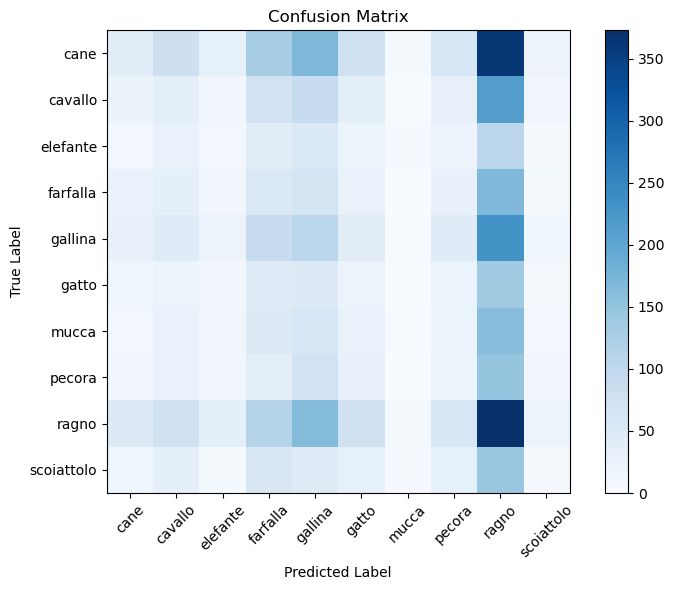

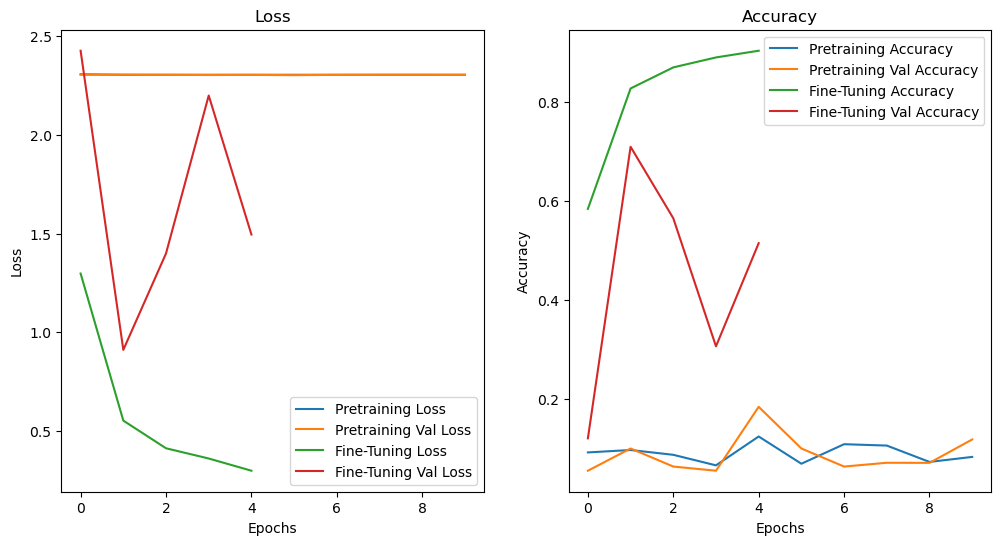

In [84]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Evaluate the fine-tuned model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Generate predictions
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Select class with highest probability

# Get real labels from validation generator
true_classes = val_generator.classes  # True labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Ensure predictions and true labels have the same length
print(f"Len true_classes: {len(true_classes)}")
print(f"Len predicted_classes: {len(predicted_classes)}")

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Visualize training history for pretraining and fine-tuning
plt.figure(figsize=(12, 6))

# Loss: training and validation
plt.subplot(1, 2, 1)
plt.plot(history_pretrain.history['loss'], label='Pretraining Loss')
plt.plot(history_pretrain.history['val_loss'], label='Pretraining Val Loss')
plt.plot(history_finetune.history['loss'], label='Fine-Tuning Loss')
plt.plot(history_finetune.history['val_loss'], label='Fine-Tuning Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy: training and validation
plt.subplot(1, 2, 2)
plt.plot(history_pretrain.history['accuracy'], label='Pretraining Accuracy')
plt.plot(history_pretrain.history['val_accuracy'], label='Pretraining Val Accuracy')
plt.plot(history_finetune.history['accuracy'], label='Fine-Tuning Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Fine-Tuning Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()